## TerrainMesh: Metric-Semantic Terrain Reconstruction from Aerial Images Using Joint 2D-3D Learning

### Load and visualize the demo data

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


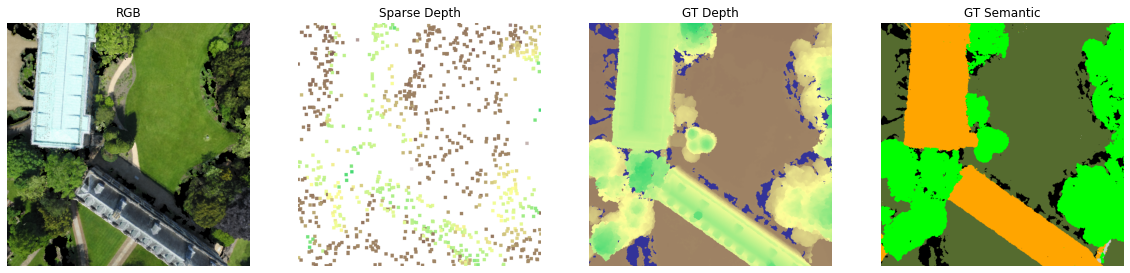

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from imageio import imread
# Some visualization functions
from utils.semantic_labels import convert_class_to_rgb_sensat_simplified 
from vis.vis import pseudo_color_map, pseudo_color_map_sparse

# image paths
rgb_file = "demo_data/RGB.png"
sparse_depth_file = "demo_data/SparseDepth.png"
gt_depth_file = "demo_data/GT_Depth.png"
gt_sem_file = "demo_data/GT_Semantics.png"

# depth scale for loading and visualization
depth_scale = 100
depth_min = 40
depth_max = 90

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(20,5))

rgb = imread(rgb_file) 
ax1.imshow(rgb)
ax1.set_title('RGB')
ax1.axis('off')

sparsedepth = imread(sparse_depth_file)/depth_scale 
sparsedepth_vis = pseudo_color_map_sparse(sparsedepth,depth_min,depth_max)
ax2.imshow(sparsedepth_vis)
ax2.set_title('Sparse Depth')
ax2.axis('off')

gt_depth = imread(gt_depth_file)/depth_scale
gt_depth_vis = pseudo_color_map(gt_depth,depth_min,depth_max)
ax3.imshow(gt_depth_vis)
ax3.set_title('GT Depth')
ax3.axis('off')

gt_sem = imread(gt_sem_file)
gt_sem_vis = convert_class_to_rgb_sensat_simplified(gt_sem)
ax4.imshow(gt_sem_vis)
ax4.set_title('GT Semantic')
ax4.axis('off')

plt.show()

### Get the 2D segmentation

Using cache found in /home/qiaojun/.cache/torch/hub/pytorch_vision_v0.8.0


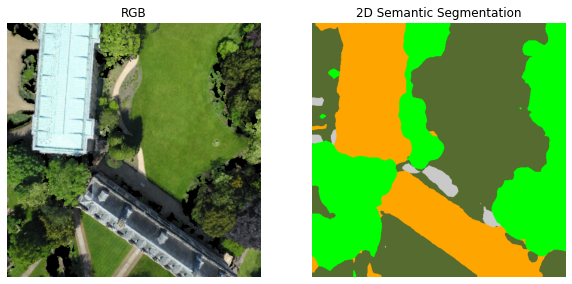

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
from config import get_sensat_cfg

save_model_path = "checkpoints/deeplab/model_best_semantic.tar"
cfg_file = "Sensat_basic.yaml"

cfg = get_sensat_cfg()
cfg.merge_from_file(cfg_file)

device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
model_2dseg = torch.hub.load('pytorch/vision:v0.8.0', 'deeplabv3_resnet50', pretrained=True)
model_2dseg.classifier[4] = nn.Conv2d(256, cfg.MODEL.DEEPLAB.NUM_CLASSES, kernel_size=1, stride=1)
model_2dseg.to(device)
checkpoint = torch.load(save_model_path)
model_2dseg.load_state_dict(checkpoint["model_state_dict"])
model_2dseg.eval()

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(rgb)
input_img = input_tensor.unsqueeze(0).to(device)
pred_semantic = model_2dseg(input_img)["out"]
pred_semantic = pred_semantic.detach().max(dim=1)[1].cpu().numpy()[0,::]
pred_semantic_vis = convert_class_to_rgb_sensat_simplified(pred_semantic)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.imshow(rgb)
ax1.set_title('RGB')
ax1.axis('off')
ax2.imshow(pred_semantic_vis)
ax2.set_title('2D Semantic Segmentation')
ax2.axis('off')
plt.show()

## Mesh initialization using sparse depth measurements

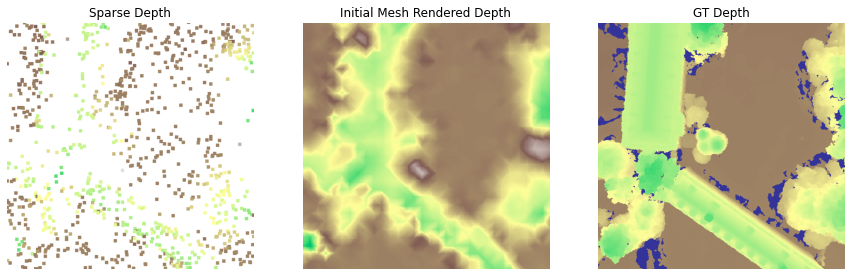

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.4982242…

In [6]:
from mesh_init.mesh_init_linear_solver import init_mesh_barycentric
from mesh_init.mesh_init_linear_solver import init_mesh_sparse
from mesh_init.mesh_renderer import mesh_render_depth
from pytorch3d.structures import Meshes
from vis.vis import texture_mesh_vertices
import meshplot as mp
import numpy as np 

num_mesh_vertices = 1024
image_size = 512
focal_length = -2
depth_min = 40
depth_max = 90

init_mesh_vertices, init_mesh_faces = init_mesh_sparse(sparsedepth,num_mesh_vertices,w_laplacian=0.5)
init_mesh_vertices_tensor = torch.tensor(init_mesh_vertices,dtype=torch.float32,device=device)
init_mesh_faces_tensor = torch.tensor(init_mesh_faces,dtype=torch.int32,device=device)
init_mesh = Meshes(verts=[init_mesh_vertices_tensor], faces=[init_mesh_faces_tensor])

init_mesh_depth = mesh_render_depth(init_mesh,image_size=image_size,focal_length=focal_length)
init_mesh_depth_vis = pseudo_color_map(init_mesh_depth,depth_min,depth_max)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.imshow(sparsedepth_vis)
ax1.set_title('Sparse Depth')
ax1.axis('off')
ax2.imshow(init_mesh_depth_vis)
ax2.set_title('Initial Mesh Rendered Depth')
ax2.axis('off')
ax3.imshow(gt_depth_vis)
ax3.set_title('GT Depth')
ax3.axis('off')
plt.show()

init_mesh_height_color = texture_mesh_vertices(init_mesh_vertices, depth_min, depth_max)
rotate_matrix = np.array([[1,0,0],[0,-1,0],[0,0,-1]])
mp.plot(init_mesh_vertices@rotate_matrix, init_mesh_faces, init_mesh_height_color)

## Mesh refinement

/home/qiaojun/miniconda3/envs/pytorch3d0.6.1/lib/python3.8/site-packages/jupyter_client/session.py:716: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.4967269…